# Base Notebook (CP-ML)

My attempt to keep an organized and complete notebook. Sections should be cross-referenced.

In [235]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

In [236]:
import os
import glob

In [237]:
from cp import CIFParser, PDBParser, StructureParser

## Data

In [238]:
data_d0 = 'E:/ic-exp-uobs/dens-0/'

In [239]:
cifs = np.array(glob.glob(os.path.join(data_d0, '*.cif')))
pdbs = np.array(glob.glob(os.path.join(data_d0, '*.pdb')))

In [240]:
def parse_multiple_structures(cif_list, pdb_list):
    multiple_struct_df = pd.DataFrame()
    for cif, pdb in zip(cif_list, pdb_list):
        structure = StructureParser(cif, pdb)
        structure.parse()
        multiple_struct_df = multiple_struct_df.append(structure.structure_df(pdb_id=True))
    return multiple_struct_df

In [241]:
def sample_files(n_structures, cif_list, pdb_list):
    permuted_indexes = np.random.permutation(len(cif_list))
    sampled_cifs = cif_list[permuted_indexes][:n_structures]
    sampled_pdbs = pdb_list[permuted_indexes][:n_structures]
    return sampled_cifs, sampled_pdbs

In [242]:
cif_sample, pdb_sample = sample_files(5, cifs, pdbs)

In [243]:
cif_sample

array(['E:/ic-exp-uobs/dens-0\\2go7_exp_uobs.cif',
       'E:/ic-exp-uobs/dens-0\\5cok_exp_uobs.cif',
       'E:/ic-exp-uobs/dens-0\\4eon_exp_uobs.cif',
       'E:/ic-exp-uobs/dens-0\\4ppo_exp_uobs.cif',
       'E:/ic-exp-uobs/dens-0\\5a5z_exp_uobs.cif'], dtype='<U39')

In [244]:
ms_df = parse_multiple_structures(cif_sample, pdb_sample)

In [247]:
ms_df.tail(10)

,index_h,index_k,index_l,FOBS,SIGFOBS,UOBS,SIGUOBS,FC,PHI,FOM,...,length_c,angle_alpha,angle_beta,angle_gamma,volume,SYNCHROTRON,SOLV,WILSON,MATTHEWS,ID
128726,41,4,2,134.4880,41.7893,0.002262,0.036458,27.3159,-31.755800,0.502513,...,92.571,90.0,90.0,90.0,1080688.061,,0.0,NULL,2.6,5a5z
128727,41,4,3,150.5790,45.4715,0.002544,0.036603,76.1621,139.385000,0.657075,...,92.571,90.0,90.0,90.0,1080688.061,,0.0,NULL,2.6,5a5z
128728,41,4,4,172.3680,47.9314,0.002931,0.036808,137.0790,117.342000,0.904878,...,92.571,90.0,90.0,90.0,1080688.061,,0.0,NULL,2.6,5a5z
128729,41,5,0,80.0179,56.1696,0.001349,0.036534,72.1596,0.000015,0.352533,...,92.571,90.0,90.0,90.0,1080688.061,,0.0,NULL,2.6,5a5z
128730,41,5,1,222.4220,49.2658,0.003753,0.036563,210.4610,94.104300,0.937181,...,92.571,90.0,90.0,90.0,1080688.061,,0.0,NULL,2.6,5a5z
128731,41,5,2,160.6220,44.5772,0.002718,0.036650,24.4419,10.035300,0.597660,...,92.571,90.0,90.0,90.0,1080688.061,,0.0,NULL,2.6,5a5z
128732,41,5,3,134.4450,43.3125,0.002286,0.036796,202.6400,143.851000,0.912343,...,92.571,90.0,90.0,90.0,1080688.061,,0.0,NULL,2.6,5a5z
128733,41,6,0,213.5160,83.7719,0.003627,0.036769,102.4420,-180.000000,0.988596,...,92.571,90.0,90.0,90.0,1080688.061,,0.0,NULL,2.6,5a5z
128734,41,6,1,111.2560,37.6039,0.001891,0.036798,93.3211,25.724200,0.675103,...,92.571,90.0,90.0,90.0,1080688.061,,0.0,NULL,2.6,5a5z
128735,41,6,2,139.4630,43.8963,0.002378,0.036886,94.2732,-143.614000,0.732204,...,92.571,90.0,90.0,90.0,1080688.061,,0.0,NULL,2.6,5a5z


## Visualization

In [248]:
ms_df.columns

Index(['index_h', 'index_k', 'index_l', 'FOBS', 'SIGFOBS', 'UOBS', 'SIGUOBS',
       'FC', 'PHI', 'FOM', 'RESOL', 'pdbx_r_free_flag', 'crystal_system',
       'IT_number', 'name_H-M_alt', 'name_Hall', 'space_group_name_H-M',
       'space_group_name_Hall', 'Int_Tables_number', 'length_a', 'length_b',
       'length_c', 'angle_alpha', 'angle_beta', 'angle_gamma', 'volume',
       'SYNCHROTRON', 'SOLV', 'WILSON', 'MATTHEWS', 'ID'],
      dtype='object')

In [249]:
dropped_columns = ['pdbx_r_free_flag', 'crystal_system',
       'IT_number', 'name_H-M_alt', 'name_Hall', 'space_group_name_H-M',
       'space_group_name_Hall', 'Int_Tables_number', 'SYNCHROTRON', 'WILSON']

In [250]:
ms_df_drop = ms_df.drop(dropped_columns, axis=1)

In [251]:
ms_df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 991521 entries, 0 to 128735
Data columns (total 21 columns):
index_h        991521 non-null int64
index_k        991521 non-null int64
index_l        991521 non-null int64
FOBS           991521 non-null float64
SIGFOBS        991521 non-null float64
UOBS           991521 non-null float64
SIGUOBS        991521 non-null float64
FC             991521 non-null float64
PHI            991521 non-null float64
FOM            991521 non-null float64
RESOL          991521 non-null float64
length_a       991521 non-null float64
length_b       991521 non-null float64
length_c       991521 non-null float64
angle_alpha    991521 non-null float64
angle_beta     991521 non-null float64
angle_gamma    991521 non-null float64
volume         991521 non-null float64
SOLV           991521 non-null float64
MATTHEWS       991521 non-null float64
ID             991521 non-null object
dtypes: float64(17), int64(3), object(1)
memory usage: 166.4+ MB


In [252]:
ms_df_drop['COSPHI'] = np.cos(ms_df_drop['PHI'])

### General Histogram

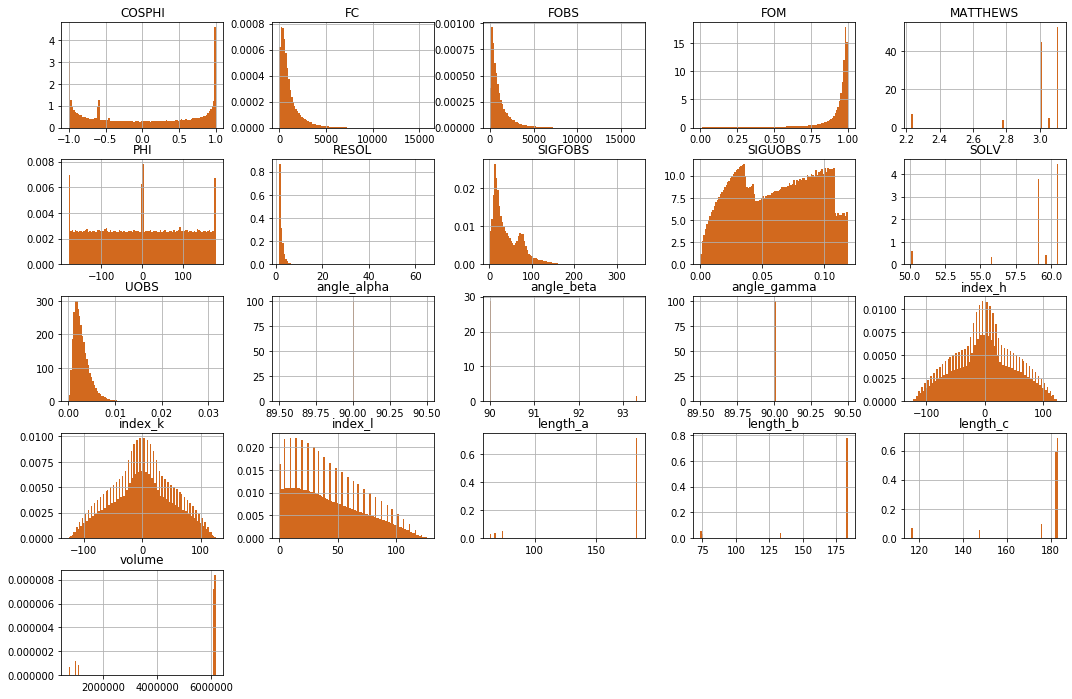

In [17]:
ms_df_drop.hist(figsize=(18,12), color='chocolate', bins=100, density=True)
plt.show()

#### Conclusions

* Very different data scales (for instance, ```UOBS``` and ```VOLUME```)
* ```PHI``` has a very uniform distribution with spikes associated with centrosymmetric reflections. ```COSPHI``` may be better than ```PHI``` because it solves the problem of circular boundary conditions on ```PHI```.
* Many distributions are heavy-tailed. Binning may an alternative (*e.g.* classes of resolution quality).

### Probing pairwise correlations

In [18]:
corr_matrix = ms_df_drop.corr()

In [19]:
from pandas.plotting import scatter_matrix

In [20]:
attribs=  ['COSPHI', 'UOBS', 'FOM', 'FOBS']

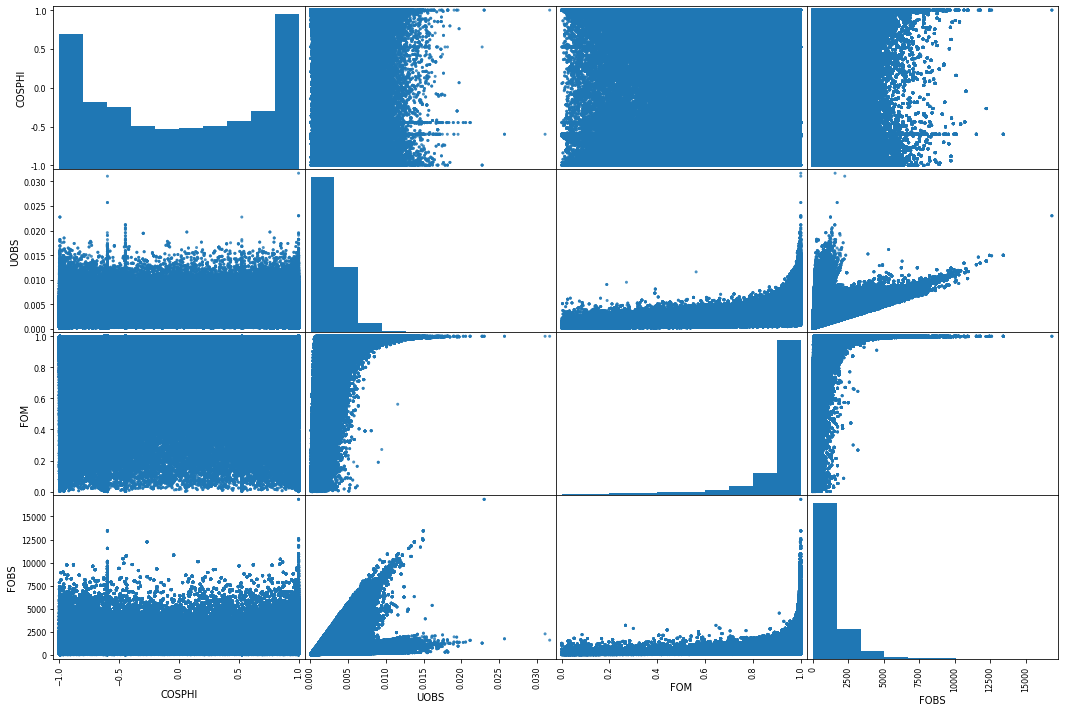

In [21]:
scatter_matrix(ms_df_drop[attribs], alpha=0.8, figsize=(18,12))
plt.show()

### Probing correlations in more dimensions

In [22]:
from mpl_toolkits.mplot3d import Axes3D

In [23]:
sampling_rate = 50

In [24]:
norm = plt.Normalize(vmin=-1, vmax=1)

In [25]:
mask = np.logical_and(ms_df_drop['RESOL'][::sampling_rate] < 4, (ms_df_drop['UOBS'][::sampling_rate] < 0.015))

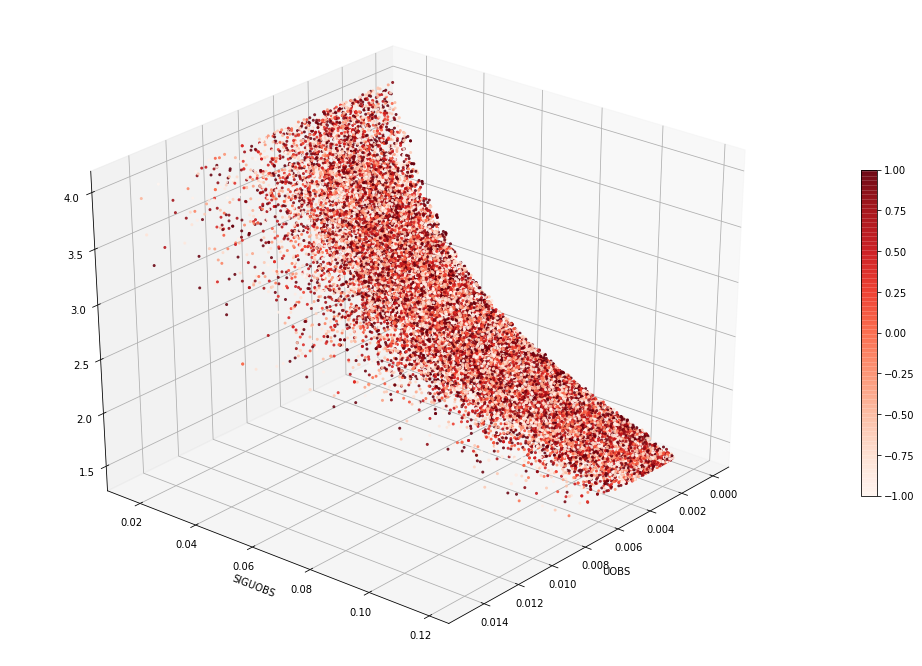

In [26]:
fig = plt.figure(figsize=(18,12))
ax = fig.gca(projection='3d')
sc = ax.scatter(ms_df_drop['UOBS'][::sampling_rate][mask], ms_df_drop['SIGUOBS'][::sampling_rate][mask],
                ms_df_drop['RESOL'][::sampling_rate][mask],
          'o',  c=ms_df_drop['COSPHI'][::sampling_rate][mask], norm=norm, cmap=plt.cm.Reds,  s=4 , alpha=0.8)
ax.set_xlabel('UOBS')
ax.set_ylabel('SIGUOBS')
plt.colorbar(sc, ax=ax, shrink=0.5)
ax.view_init(30, 40)
plt.show()

## Feature Engineering

In [253]:
labels = ms_df_drop['COSPHI']

In [254]:
ms_df_drop.drop(['COSPHI'], axis=1, inplace=True)

In [255]:
ms_df_drop.head(10)

,index_h,index_k,index_l,FOBS,SIGFOBS,UOBS,SIGUOBS,FC,PHI,FOM,...,length_a,length_b,length_c,angle_alpha,angle_beta,angle_gamma,volume,SOLV,MATTHEWS,ID
0,-73,28,1,94.2651,29.8769,0.001097,0.056487,103.16300,137.310000,0.628283,...,155.0,155.0,88.44,90.0,90.0,120.0,1840105.714,60.25,3.12,2go7
1,-73,28,2,169.5540,45.2736,0.001977,0.056583,183.57500,0.103928,0.909382,...,155.0,155.0,88.44,90.0,90.0,120.0,1840105.714,60.25,3.12,2go7
2,-73,29,1,100.3030,31.3631,0.001162,0.056265,100.47400,179.731000,0.644776,...,155.0,155.0,88.44,90.0,90.0,120.0,1840105.714,60.25,3.12,2go7
3,-73,29,2,120.6590,34.5303,0.001400,0.056361,9.06585,-53.736000,0.325391,...,155.0,155.0,88.44,90.0,90.0,120.0,1840105.714,60.25,3.12,2go7
4,-73,29,3,212.4250,30.4029,0.002473,0.056521,130.14600,-139.441000,0.850244,...,155.0,155.0,88.44,90.0,90.0,120.0,1840105.714,60.25,3.12,2go7
5,-73,30,1,239.9070,27.6209,0.002767,0.056071,188.63800,128.422000,0.930974,...,155.0,155.0,88.44,90.0,90.0,120.0,1840105.714,60.25,3.12,2go7
6,-73,30,2,124.1360,34.2411,0.001435,0.056167,94.01000,54.062300,0.760066,...,155.0,155.0,88.44,90.0,90.0,120.0,1840105.714,60.25,3.12,2go7
7,-73,30,3,85.8954,28.3356,0.000996,0.056327,58.38450,-44.310100,0.630241,...,155.0,155.0,88.44,90.0,90.0,120.0,1840105.714,60.25,3.12,2go7
8,-73,30,4,152.1590,35.2731,0.001773,0.056550,154.81900,71.724400,0.588829,...,155.0,155.0,88.44,90.0,90.0,120.0,1840105.714,60.25,3.12,2go7
9,-73,31,1,113.2650,32.1641,0.001302,0.055904,80.17280,80.529200,0.663151,...,155.0,155.0,88.44,90.0,90.0,120.0,1840105.714,60.25,3.12,2go7


In [256]:
def miller_indexes_to_plane(df, indexes=['index_h', 'index_k', 'index_l'], 
                        axes=['length_a', 'length_b', 'length_c']):
    temp_df = df.copy()
    for index, ax in zip(indexes, axes):
        plane_name = 'plane_'+ index[-1]
        temp_df.loc[df[index] == 0, index] = np.inf
        df[plane_name] = temp_df[ax]/temp_df[index]
    return df

In [367]:
def angle_to_trig_rep(df, angles=['angle_alpha', 'angle_beta', 'angle_gamma']):
    for angle in angles:
        cos_angle_name = 'cos_angle_'+angle.split('_')[-1]
        sin_angle_name = 'sin_angle_'+angle.split('_')[-1]
        df[cos_angle_name] = np.cos(df[angle])
        df[sin_angle_name] = np.sin(df[angle])
    return df

In [258]:
ms_df_fe = miller_indexes_to_plane(ms_df_drop)

In [259]:
ms_df_fe = angle_to_cossine_rep(ms_df_fe)

In [260]:
base_df = ms_df_fe.drop(['index_h', 'index_k', 'index_l', 'FOBS', 'SIGFOBS', 'FOM', 'ID', 'FC'], axis=1)

In [261]:
base_df

,UOBS,SIGUOBS,PHI,RESOL,length_a,length_b,length_c,angle_alpha,angle_beta,angle_gamma,volume,SOLV,MATTHEWS,plane_h,plane_k,plane_l
0,0.001097,0.056487,137.310000,2.10376,155.000,155.000,88.440,-0.448074,-0.448074,0.814181,1840105.714,60.25,3.12,-2.123288,5.535714,88.4400
1,0.001977,0.056583,0.103928,2.10197,155.000,155.000,88.440,-0.448074,-0.448074,0.814181,1840105.714,60.25,3.12,-2.123288,5.535714,44.2200
2,0.001162,0.056265,179.731000,2.10790,155.000,155.000,88.440,-0.448074,-0.448074,0.814181,1840105.714,60.25,3.12,-2.123288,5.344828,88.4400
3,0.001400,0.056361,-53.736000,2.10611,155.000,155.000,88.440,-0.448074,-0.448074,0.814181,1840105.714,60.25,3.12,-2.123288,5.344828,44.2200
4,0.002473,0.056521,-139.441000,2.10313,155.000,155.000,88.440,-0.448074,-0.448074,0.814181,1840105.714,60.25,3.12,-2.123288,5.344828,29.4800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128731,0.002718,0.036650,10.035300,2.61174,108.047,108.047,92.571,-0.448074,-0.448074,-0.448074,1080688.061,0.00,2.60,2.635293,21.609400,46.2855
128732,0.002286,0.036796,143.851000,2.60656,108.047,108.047,92.571,-0.448074,-0.448074,-0.448074,1080688.061,0.00,2.60,2.635293,21.609400,30.8570
128733,0.003627,0.036769,-180.000000,2.60752,108.047,108.047,92.571,-0.448074,-0.448074,-0.448074,1080688.061,0.00,2.60,2.635293,18.007833,0.0000
128734,0.001891,0.036798,25.724200,2.60649,108.047,108.047,92.571,-0.448074,-0.448074,-0.448074,1080688.061,0.00,2.60,2.635293,18.007833,92.5710


In [262]:
from sklearn.preprocessing import StandardScaler

In [263]:
scaler = StandardScaler()

In [264]:
scaler.fit(base_df)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [265]:
scaled = scaler.transform(base_df)

## Models

In [267]:
from sklearn.ensemble import RandomForestRegressor

In [268]:
from sklearn.model_selection import cross_val_predict

In [269]:
rfr = RandomForestRegressor(n_estimators=80, max_depth=250, max_leaf_nodes=300)

In [270]:
scaled

array([[-8.76805379e-01,  1.37053226e+00,  1.31714382e+00, ...,
        -9.59177948e-02,  2.14167069e-01,  3.74503578e+00],
       [-4.54332441e-01,  1.37613484e+00,  3.21545794e-03, ...,
        -9.59177948e-02,  2.14167069e-01,  1.55792160e+00],
       [-8.45690854e-01,  1.35756863e+00,  1.72338061e+00, ...,
        -9.59177948e-02,  2.06797128e-01,  3.74503578e+00],
       ...,
       [ 3.37726903e-01,  2.18603718e-01, -1.72151622e+00, ...,
         1.01499494e-01,  6.95702865e-01, -6.29192569e-01],
       [-4.95293578e-01,  2.20303770e-01,  2.48563214e-01, ...,
         1.01499494e-01,  6.95702865e-01,  3.94935438e+00],
       [-2.61860225e-01,  2.25421453e-01, -1.37307248e+00, ...,
         1.01499494e-01,  6.95702865e-01,  1.66008091e+00]])

In [271]:
labels.values

array([ 0.60575909,  0.99460434, -0.7898581 , ..., -0.59846007,
        0.83012819,  0.62218784])

In [272]:
cv_rfr = cross_val_predict(rfr, scaled, labels.values, cv=2, verbose=5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 33.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 33.6min finished


In [273]:
cv_rfr.shape

(991521,)

In [274]:
labels.shape

(991521,)

In [275]:
a = list(range(labels.shape[0]))

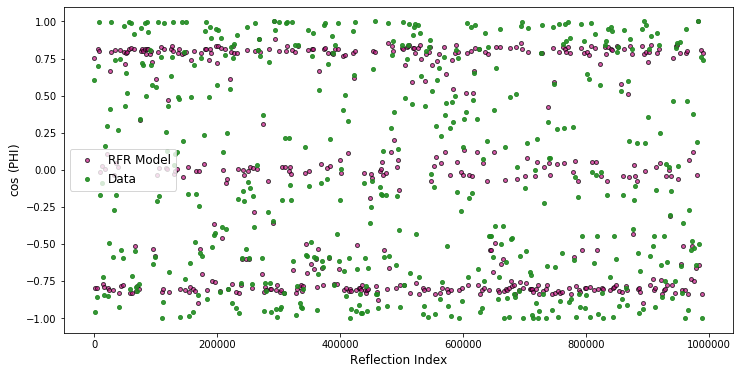

In [364]:
fig = plt.figure(figsize=(12,6))
plt.plot(a[::2000], cv_rfr[::2000], 'o', markersize=4, alpha=0.7, color='k', mfc='mediumvioletred', label='RFR Model')
plt.plot(a[::2000], labels[::2000], 'o', markersize=4, alpha=0.9, color='forestgreen', label='Data')
#plt.xlim(2025.5, 2050.5)
plt.xlabel('Reflection Index', fontsize=12)
plt.ylabel(r'$\cos$ (PHI)', fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [344]:
from sklearn.metrics import mean_squared_error

In [288]:
cv_rfr_deg = np.arccos(cv_rfr)*180.0/np.pi

In [289]:
labels_deg = np.arccos(labels)*180.0/np.pi

In [290]:
mean_squared_error(cv_rfr, labels)

0.02648440680332152

In [291]:
np.sqrt(mean_squared_error(cv_rfr_deg, labels_deg.values))

16.366357205268997

In [293]:
np.arccos(labels)*180.0/np.pi

0          52.716515
1           5.954636
2         142.172252
3         161.153992
4          69.380791
             ...    
128731    145.019664
128732     37.944821
128733    126.759688
128734     33.888091
128735     51.523921
Name: COSPHI, Length: 991521, dtype: float64

In [294]:
cv_rfr_deg

array([ 41.26578385,  12.3077787 , 154.14615031, ..., 127.31426318,
        33.69337111,  40.99279221])

In [295]:
labels_deg

0          52.716515
1           5.954636
2         142.172252
3         161.153992
4          69.380791
             ...    
128731    145.019664
128732     37.944821
128733    126.759688
128734     33.888091
128735     51.523921
Name: COSPHI, Length: 991521, dtype: float64

(array([7.94703106e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.19965056e-06, 4.89685717e-03, 1.54382385e-02, 2.34359238e-02,
        1.50431483e-02, 5.16434260e-03]),
 array([-116.9177743 , -101.30794032,  -85.69810635,  -70.08827237,
         -54.4784384 ,  -38.86860442,  -23.25877045,   -7.64893647,
           7.9608975 ,   23.57073148,   39.18056545]),
 <a list of 10 Patch objects>)

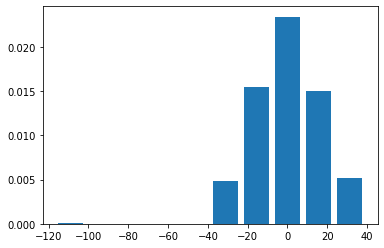

In [296]:
plt.hist(cv_rfr_deg-labels_deg.values, rwidth=0.8, density=True)